<a href="https://colab.research.google.com/github/YangWorking/Deep_learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Fetch data from the provided URL
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale"
response = requests.get(url)
data_lines = response.text.split('\n')

X = []
y = []

for line in data_lines:
    if line:
        parts = line.strip().split()
        label = int(parts[0])
        features = [float(part.split(':')[1]) for part in parts[1:]]

        # Ensure all feature vectors have the same length (8 in this case)
        if len(features) == 8:
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)
y = (y + 1) / 2

# Split the data into training, validation, and testing sets
torch.manual_seed(1881911)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define a MLP model using PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(8, 32)  # Input layer (8 features) to hidden layer with 32 neurons
        self.relu = nn.ReLU() # Rectified linear unit
        self.fc2 = nn.Linear(32, 2)  # Hidden layer to output layer (2 neurons with tanh activation)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.tanh(x)  # Use tanh activation for class labels +1 and -1

def hyperparameter_lr_tuning(learning_rate, num_epochs):
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        _, predicted = torch.max(val_outputs, 1)
        accuracy = (predicted == y_val).sum().item() / len(y_val)

    return train_losses, val_losses, accuracy

def hyperparameter_epochs_tuning(learning_rate, num_epochs):
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        _, predicted = torch.max(val_outputs, 1)
        accuracy = (predicted == y_val).sum().item() / len(y_val)

    return train_losses, val_losses, accuracy


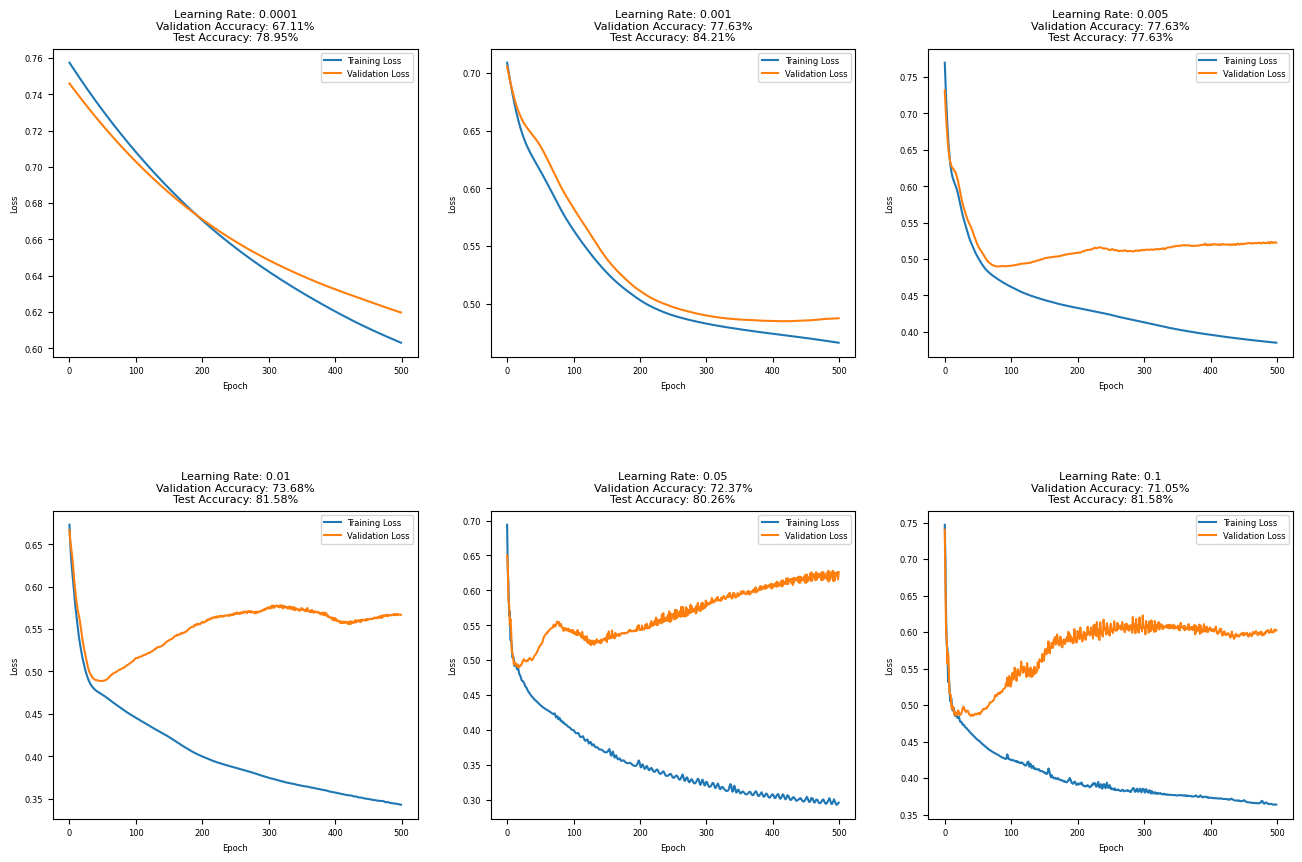

In [ ]:
# Learning rate tuning
torch.manual_seed(1881911)
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
tuning_results = []


for lr in learning_rates:
    num_epochs = 500
    train_losses, val_losses, val_accuracy = hyperparameter_lr_tuning(lr, num_epochs)


    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy = (predicted_test == y_test).sum().item() / len(y_test)

    tuning_results.append((lr, train_losses, val_losses, val_accuracy, test_accuracy))

fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.subplots_adjust(hspace=0.5)

for i, (lr, train_losses, val_losses, val_accuracy, test_accuracy) in enumerate(tuning_results):
    row = i // 3
    col = i % 3
    axs[row, col].plot(train_losses, label='Training Loss')
    axs[row, col].plot(val_losses, label='Validation Loss')
    axs[row, col].set_xlabel("Epoch")
    axs[row, col].set_ylabel("Loss")
    axs[row, col].set_title(f"Learning Rate: {lr}\nValidation Accuracy: {val_accuracy * 100:.2f}%\nTest Accuracy: {test_accuracy * 100:.2f}%")
    axs[row, col].legend()

if len(tuning_results) < 6:
    for i in range(len(tuning_results), 6):
        row = i // 3
        col = i % 3
        axs[row, col].axis('off')

plt.show()

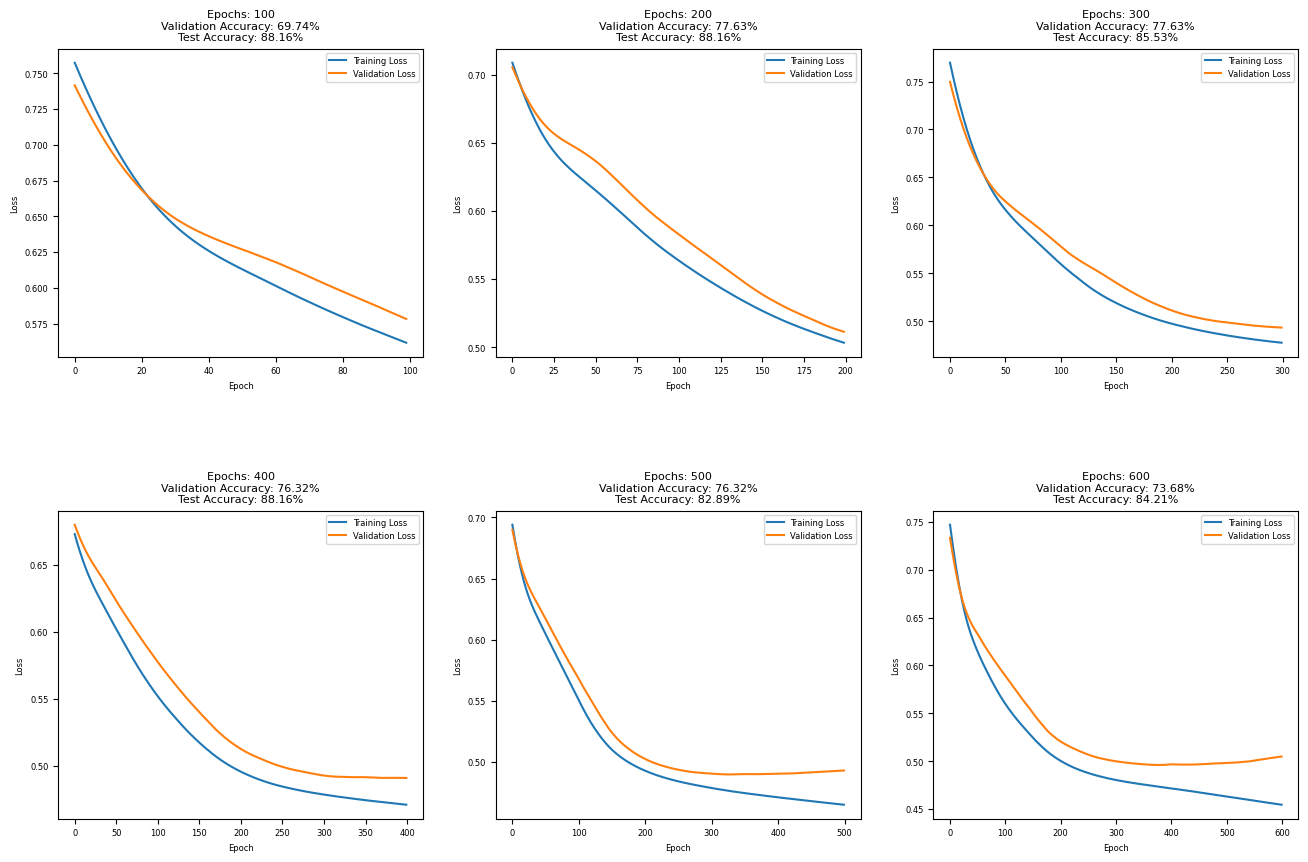

In [ ]:
# Tuning epochs values
torch.manual_seed(1881911)
fixed_learning_rate = 0.001
num_epochs_values = [100, 200, 300, 400, 500, 600]
tuning_results = []

for num_epochs in num_epochs_values:
    train_losses, val_losses, val_accuracy = hyperparameter_epochs_tuning(fixed_learning_rate, num_epochs)


    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=fixed_learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy = (predicted_test == y_test).sum().item() / len(y_test)

    tuning_results.append((num_epochs, train_losses, val_losses, val_accuracy, test_accuracy))

fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.subplots_adjust(hspace=0.5)

for i, (num_epochs, train_losses, val_losses, val_accuracy, test_accuracy) in enumerate(tuning_results):
    row = i // 3
    col = i % 3
    axs[row, col].plot(train_losses, label='Training Loss')
    axs[row, col].plot(val_losses, label='Validation Loss')
    axs[row, col].set_xlabel("Epoch")
    axs[row, col].set_ylabel("Loss")
    axs[row, col].set_title(f"Epochs: {num_epochs}\nValidation Accuracy: {val_accuracy * 100:.2f}%\nTest Accuracy: {test_accuracy * 100:.2f}%")
    axs[row, col].legend()

if len(tuning_results) < 6:
    for i in range(len(tuning_results), 6):
        row = i // 3
        col = i % 3
        axs[row, col].axis('off')

plt.show()

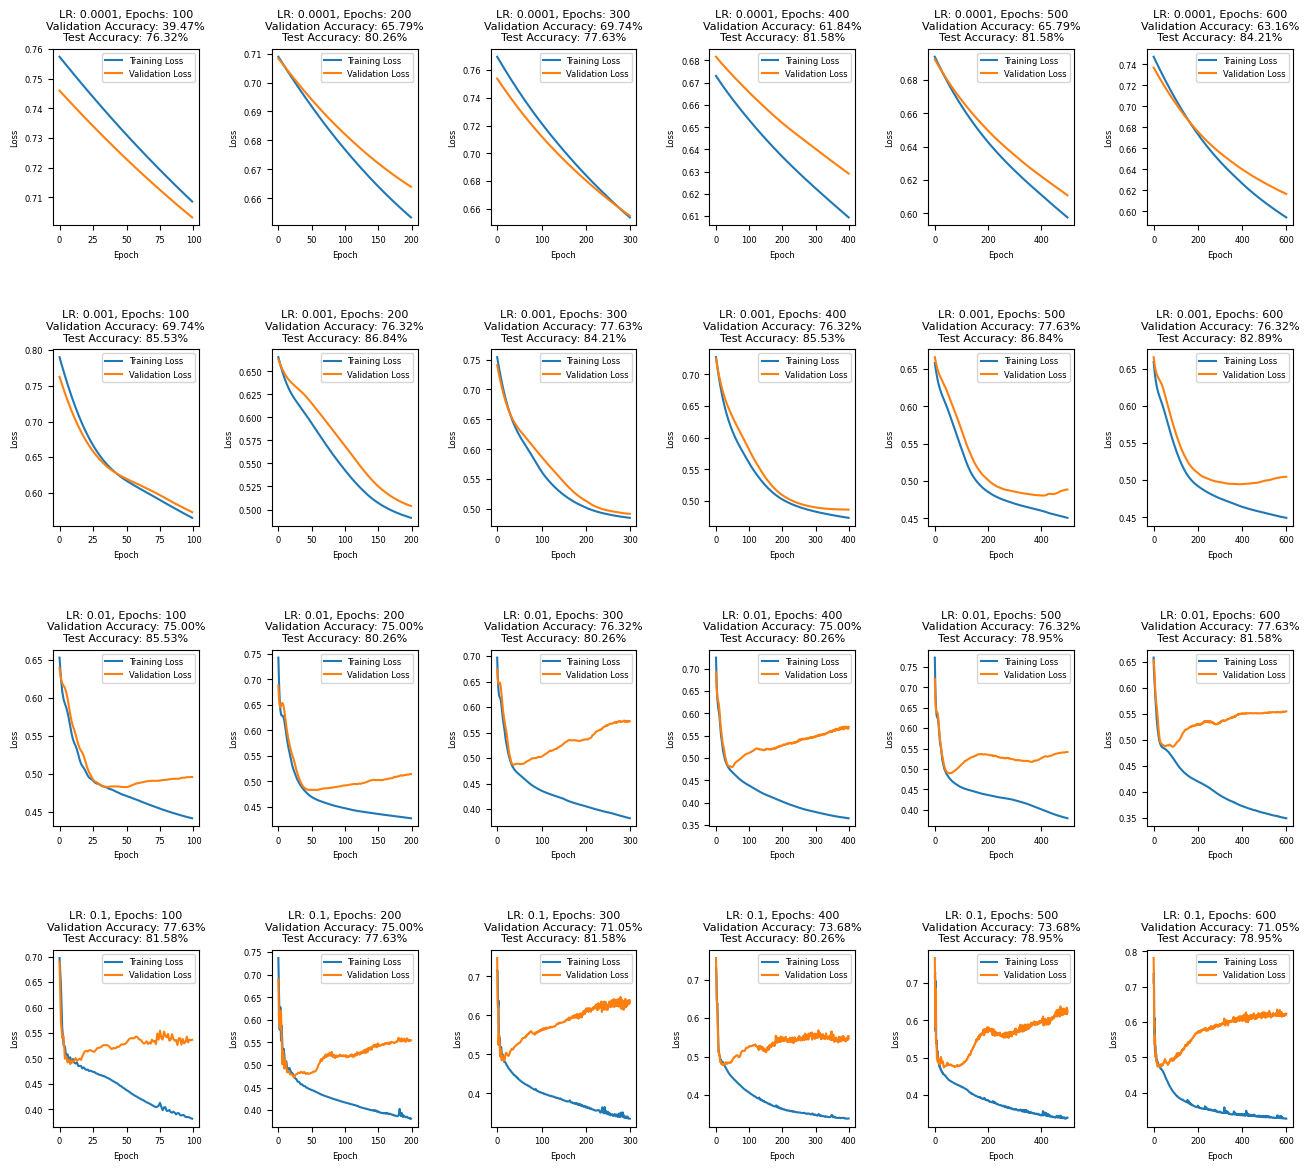

    Learning Rate  Epochs  Validation Accuracy  Test Accuracy
0          0.0010     500             0.776316       0.868421
1          0.0010     300             0.776316       0.842105
2          0.0100     600             0.776316       0.815789
3          0.1000     100             0.776316       0.815789
4          0.0010     200             0.763158       0.868421
5          0.0010     400             0.763158       0.855263
6          0.0010     600             0.763158       0.828947
7          0.0100     300             0.763158       0.802632
8          0.0100     500             0.763158       0.789474
9          0.0100     100             0.750000       0.855263
10         0.0100     200             0.750000       0.802632
11         0.0100     400             0.750000       0.802632
12         0.1000     200             0.750000       0.776316
13         0.1000     400             0.736842       0.802632
14         0.1000     500             0.736842       0.789474
15      

In [ ]:
# Define a range of learning rates and epochs to tune
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs_values = [100, 200, 300, 400, 500, 600]
tuning_results = []
torch.manual_seed(1881911)

for lr in learning_rates:
    for num_epochs in num_epochs_values:
        train_losses, val_losses, val_accuracy = hyperparameter_epochs_tuning(lr, num_epochs)

        model = MLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted_test = torch.max(test_outputs, 1)
            test_accuracy = (predicted_test == y_test).sum().item() / len(y_test)

        tuning_results.append((lr, num_epochs, train_losses, val_losses, val_accuracy, test_accuracy))

num_rows = len(learning_rates)
num_cols = len(num_epochs_values)

# Adjust font size for titles, labels, and legends
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('legend', fontsize=6)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

for i, (lr, num_epochs, train_losses, val_losses, val_accuracy, test_accuracy) in enumerate(tuning_results):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(train_losses, label='Training Loss')
    axs[row, col].plot(val_losses, label='Validation Loss')
    axs[row, col].set_xlabel("Epoch")
    axs[row, col].set_ylabel("Loss")
    axs[row, col].set_title(f"LR: {lr}, Epochs: {num_epochs}\nValidation Accuracy: {val_accuracy * 100:.2f}%\nTest Accuracy: {test_accuracy * 100:.2f}%")
    axs[row, col].legend()

if len(tuning_results) < (num_rows * num_cols):
    for i in range(len(tuning_results), (num_rows * num_cols)):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')
plt.show()

# Create the final result table
import pandas as pd
results_tuples = [(lr, num_epochs, val_accuracy, test_accuracy) for lr, num_epochs, _, _, val_accuracy, test_accuracy in tuning_results]
results_df = pd.DataFrame(results_tuples, columns=["Learning Rate", "Epochs", "Validation Accuracy", "Test Accuracy"])
results_df = results_df.sort_values(by=["Validation Accuracy", "Test Accuracy"], ascending=[False, False])
results_df = results_df.reset_index(drop=True)
print(results_df)